In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

df = pd.read_csv("Joules_of_Siam_Data - Dataset_Strech.csv")
df.head()

,Year,Month,Population,Temperature,CPI,Peak
0,2022,12,66.090000,26.300000,106.470000,27124.7
1,2022,11,66.083333,26.249167,106.470000,27832.7
2,2022,10,66.076667,26.198333,106.470000,27041.9
3,2022,9,66.070000,26.147500,106.470000,27808.0
4,2022,8,66.063333,26.096667,108.503333,28951.8


In [3]:
df.shape

(252, 6)

In [4]:
df['Date'] = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2)

In [5]:
X = df[['Date','Peak']]
X.head()

,Date,Peak
0,2022-12,27124.7
1,2022-11,27832.7
2,2022-10,27041.9
3,2022-09,27808.0
4,2022-08,28951.8


In [6]:
X = X.iloc[::-1]
X = X.reset_index(drop=False)
X.drop(columns = ['index'], inplace=True)
X.set_index('Date', inplace=True)
X.head()

,Peak
Date,
2002-01,14552.5
2002-02,15260.8
2002-03,16485.3
2002-04,16681.1
2002-05,16293.1


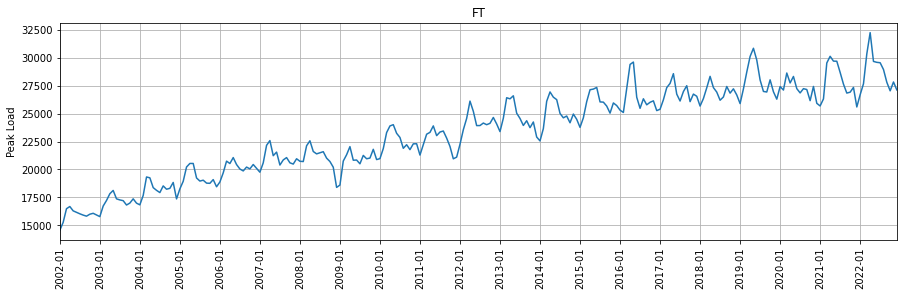

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.title('FT')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X)
plt.xticks(X.index[::12], rotation=90)
plt.show()

In [120]:
y = X.Peak.values.astype(float)

test_size = 12
window_size = 24

train_set = y[:-test_size]
test_set  = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 240
Test:  12


In [121]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled: {train_norm[0]}')

First item, original: 14552.5
First item, scaled: [-1.]


In [122]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [123]:
train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 216


In [12]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]
    
torch.manual_seed(101)
model = LSTMnetwork()
model

LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [13]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training 

In [97]:
epochs = 1000

for i in range(epochs):
    for seq, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # apply the model
        y_pred = model(seq)

        # update parameters
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    if (i+1) % 100 == 0:
        # OPTIONAL print statement
        print(f'{i+1} of {epochs} epochs completed')

100 of 1000 epochs completed
200 of 1000 epochs completed
300 of 1000 epochs completed
400 of 1000 epochs completed
500 of 1000 epochs completed
600 of 1000 epochs completed
700 of 1000 epochs completed
800 of 1000 epochs completed
900 of 1000 epochs completed
1000 of 1000 epochs completed


## Testing 

In [109]:
future = 12 #months
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future): #future
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        
# preds[window_size:]

In [110]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
# true_predictions = true_predictions.astype(str).tolist()

In [111]:
true_predictions = true_predictions.reshape(-1)

In [112]:
day = np.arange('2022-01', '2023-01', dtype='datetime64[M]') #.astype('datetime64[D]')
day = day.astype(str).tolist()

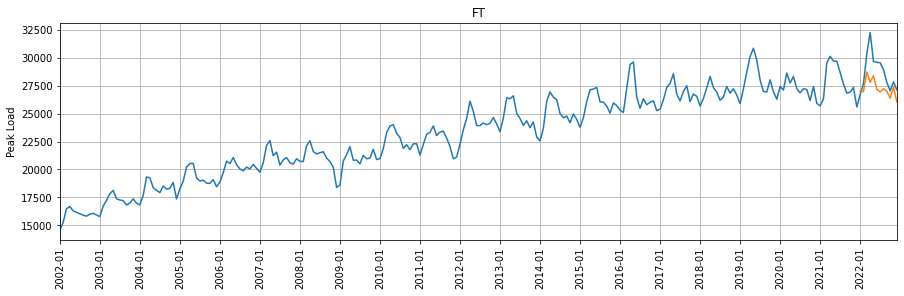

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.title('FT')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X)
plt.plot(day, true_predictions)
plt.xticks(X.index[::12], rotation=90)
plt.show()

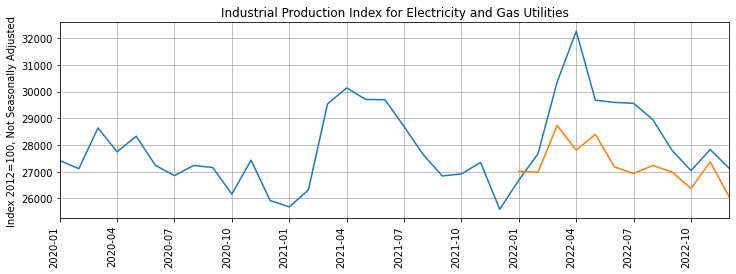

In [114]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(X['Peak']['2020-01':])
plt.plot(day, true_predictions)
plt.xticks(X['Peak']['2020-01':].index[::3], rotation=90)
plt.show()

## Inference 

In [115]:
future = 60 #months
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future): #future
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        
# preds[window_size:]

In [116]:
true_predictions = scaler.inverse_transform(np.array(preds[-future:]).reshape(-1, 1))
# true_predictions = true_predictions.astype(str).tolist()

In [117]:
true_predictions = true_predictions.reshape(-1)
true_predictions.shape

(60,)

In [118]:
day = np.arange('2022-01', '2027-01', dtype='datetime64[M]') #.astype('datetime64[D]')
day = day.astype(str).tolist()
len(day)

60

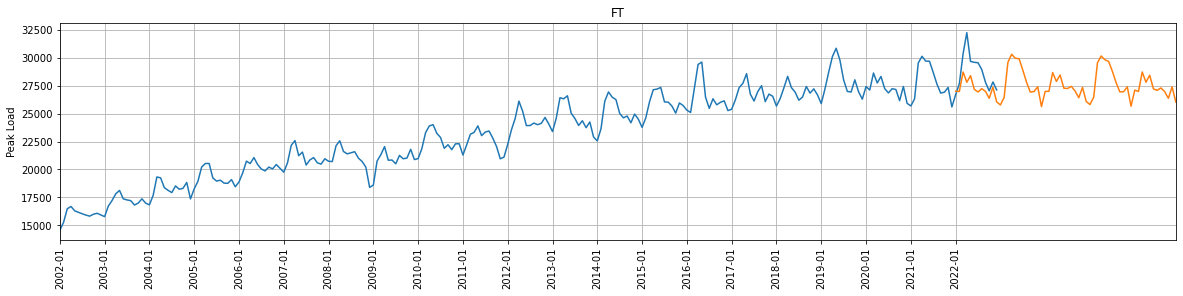

In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.title('FT')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X)
plt.plot(day, true_predictions)
plt.xticks(X.index[::12], rotation=90)
plt.show()